In [1]:
import os
import pickle

# Third-party
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.special import logsumexp
from scipy.optimize import minimize
from numba import jit

from pyia import GaiaData
from gala.mpl_style import laguna, hesperia

In [2]:
gc_frame = coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8.122*u.kpc)

In [3]:
# filename = '../data/rv-good-plx.fits'
filename = '/Users/apricewhelan/data/GaiaDR2/rv-good-plx.fits'
g = GaiaData(filename)

c = g.skycoord
galcen = c.transform_to(gc_frame)

In [4]:
gal = c.galactic
gal.set_representation_cls('cartesian')

In [5]:
xyz = np.vstack((gal.u.to(u.pc).value, 
                 gal.v.to(u.pc).value,
                 gal.w.to(u.pc).value)).T

UVW = np.vstack((gal.U.to(u.km/u.s).value, 
                 gal.V.to(u.km/u.s).value, 
                 gal.W.to(u.km/u.s).value)).T

disk_vmask = np.linalg.norm(UVW, axis=1) < 200.

In [6]:
_cyl = gal.represent_as('cylindrical')
mask_r100 = (_cyl.rho < 100*u.pc) & (np.abs(_cyl.z) < 150*u.pc)
mask_r300 = (_cyl.rho < 300*u.pc) & (np.abs(_cyl.z) < 500*u.pc)
mask_r500 = (_cyl.rho < 500*u.pc) & (np.abs(_cyl.z) < 500*u.pc)
mask_r100.sum(), mask_r500.sum()

(131348, 1880612)

### Fit a GMM to the local velocity distribution:

In [7]:
from sklearn.mixture import GaussianMixture

In [8]:
local_v = UVW[disk_vmask & mask_r100]
local_x = xyz[disk_vmask & mask_r100]

In [ ]:
idx = np.random.choice([] len(local_v))
train_mask = np.zeros(len(local_v))
X_train = 

n_components = 2 ** np.arange(3, 10, 1)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xtrain)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

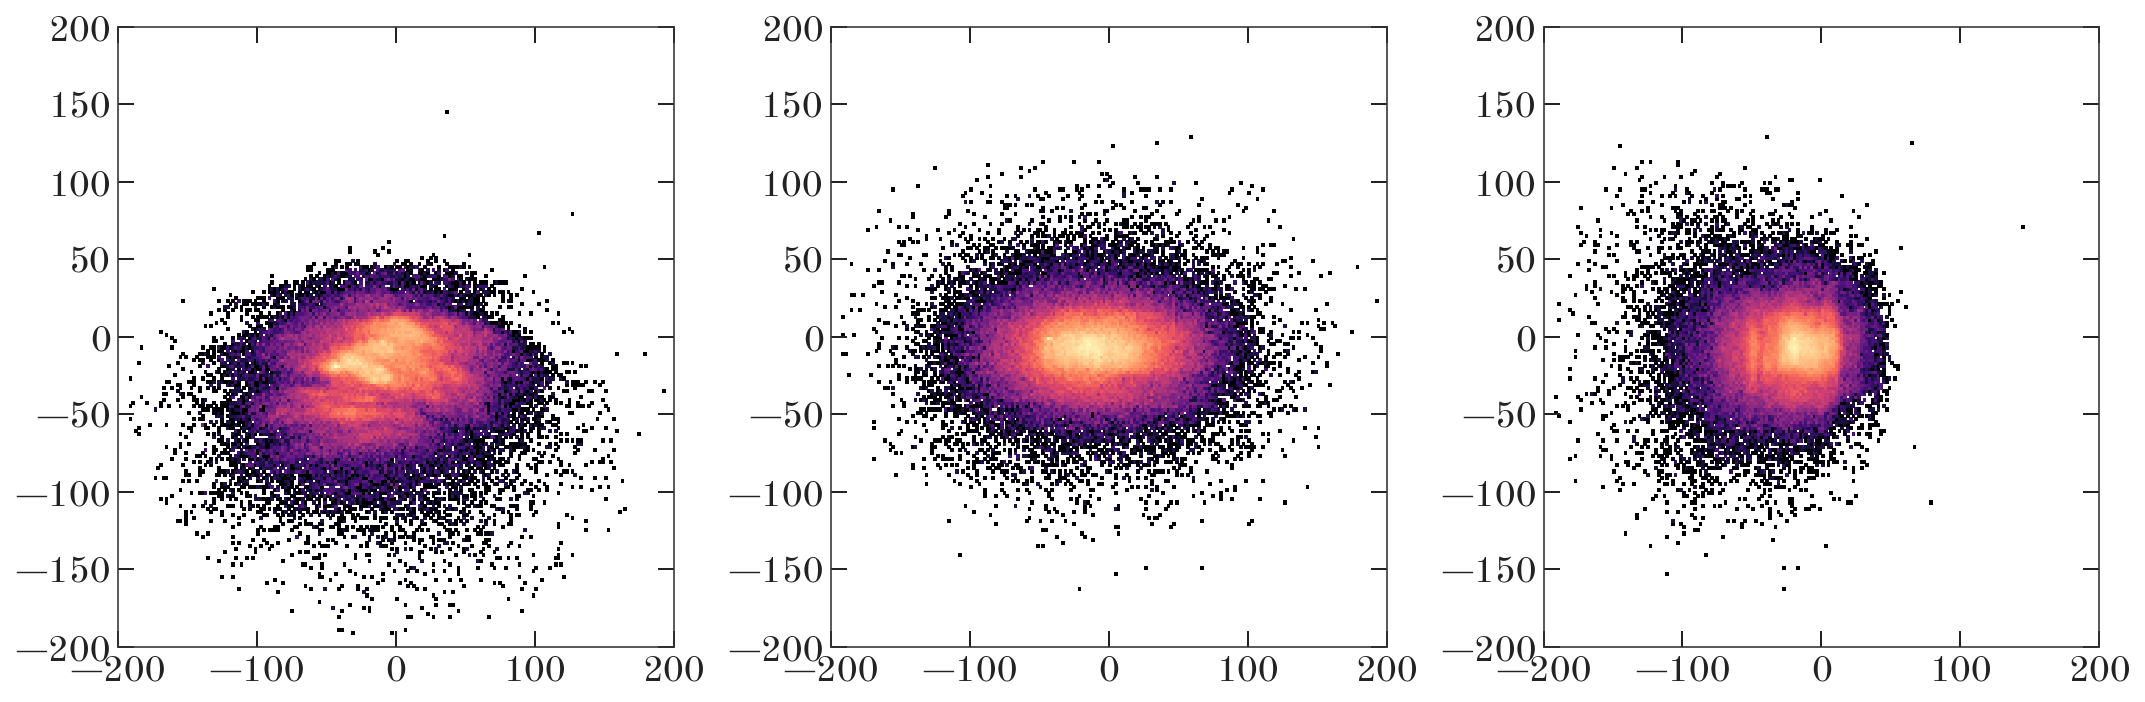

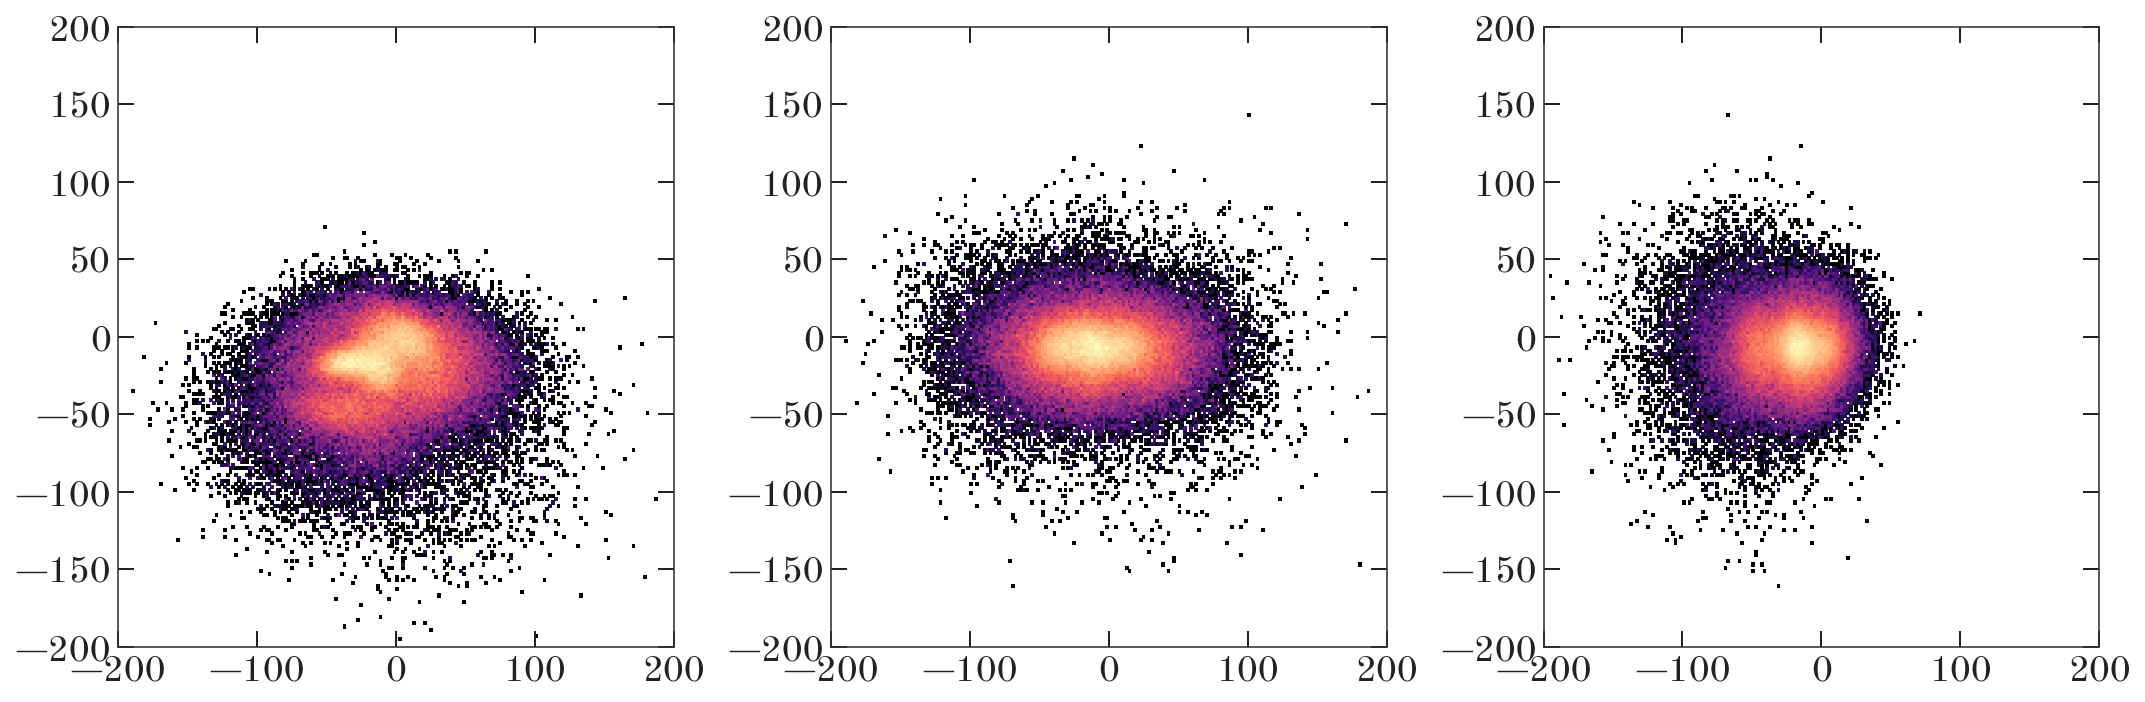

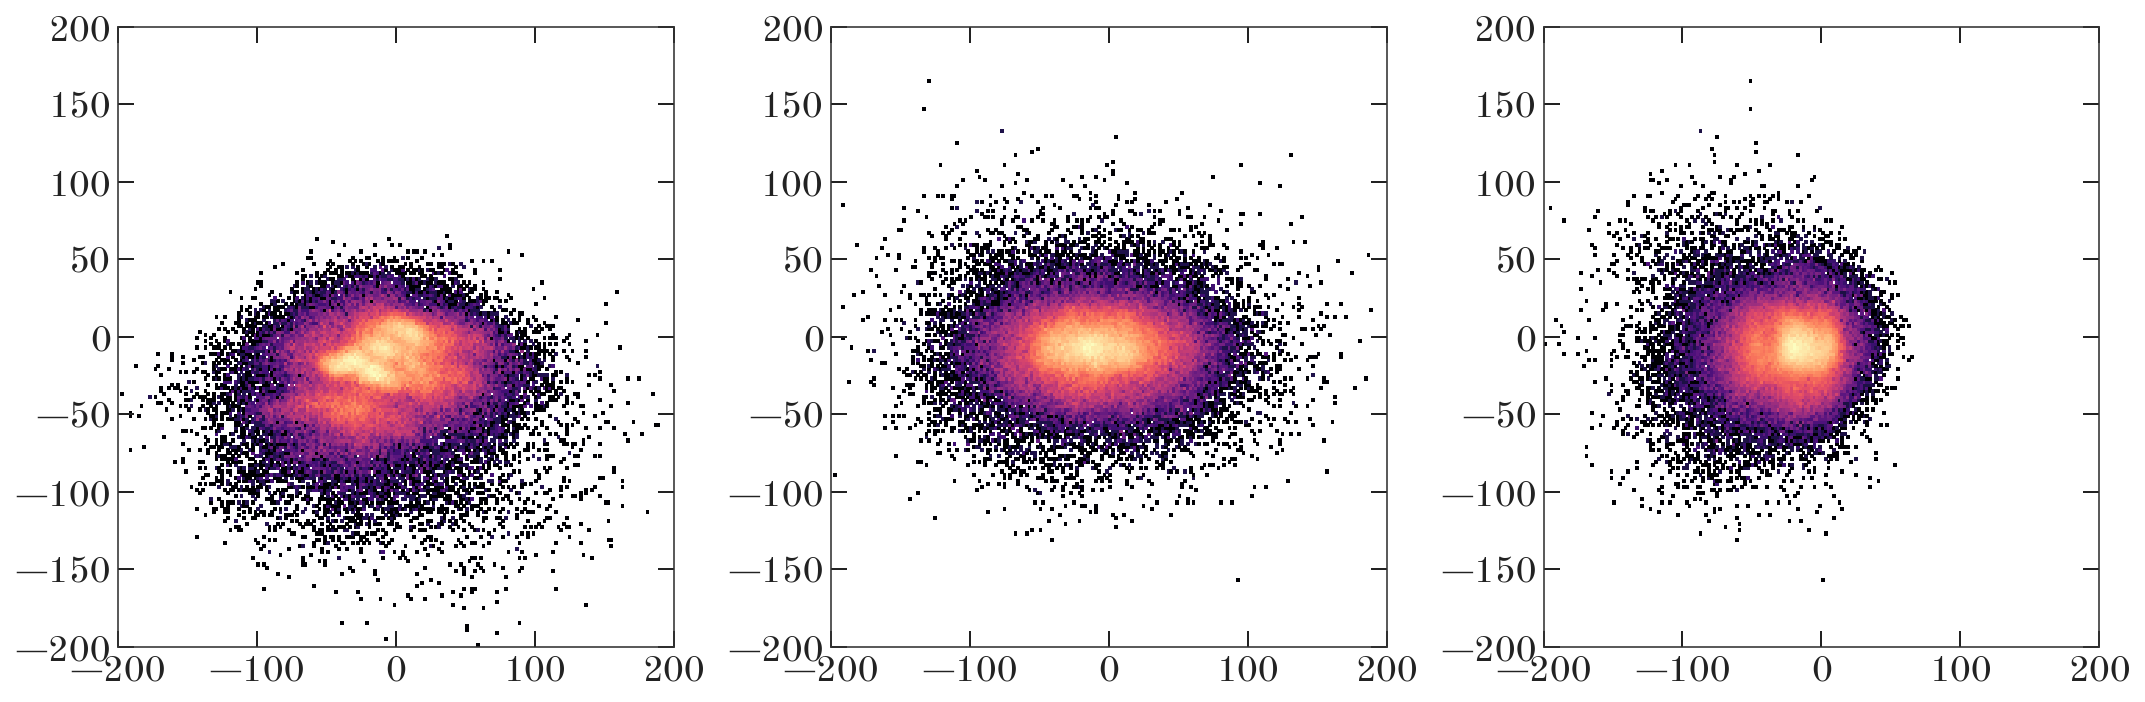

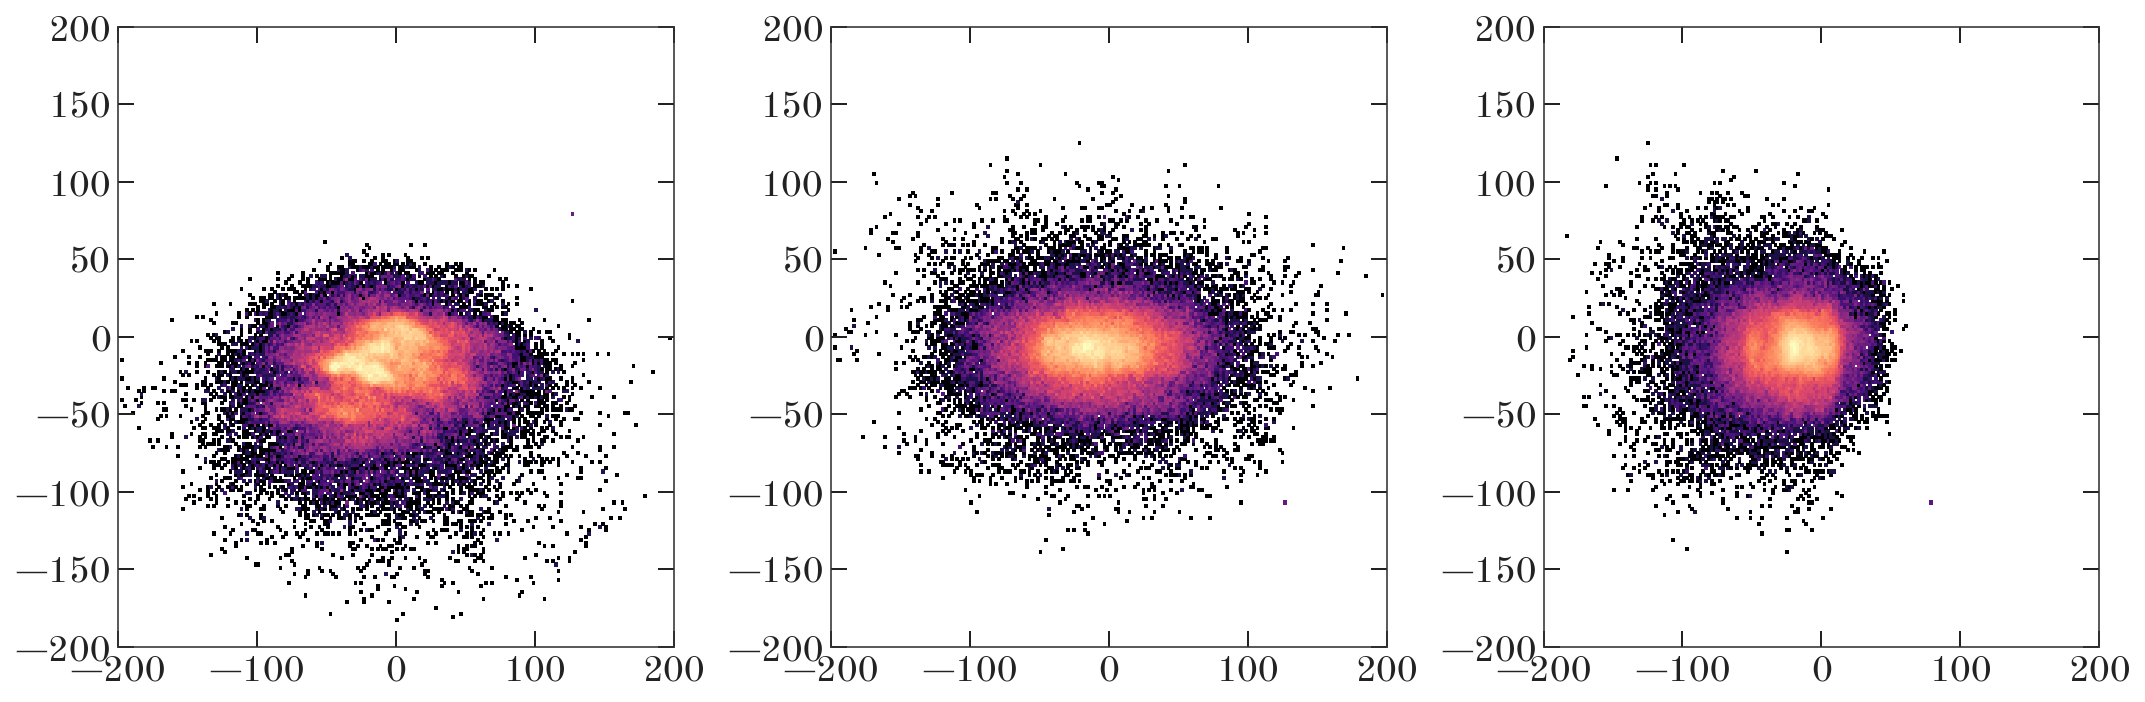

In [44]:
X = local_v
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist2d(X[:, 0], X[:, 1], bins=bins, norm=mpl.colors.LogNorm())
axes[1].hist2d(X[:, 0], X[:, 2], bins=bins, norm=mpl.colors.LogNorm())
axes[2].hist2d(X[:, 1], X[:, 2], bins=bins, norm=mpl.colors.LogNorm());
fig.set_facecolor('w')
fig.tight_layout()
        
# ---

for K in [16, 16*4, 16*4*4]:
    gmm = GaussianMixture(n_components=K, covariance_type='full')
    gmm.fit(local_v[::4])

    X, _ = gmm.sample(100_000)

    bins = np.arange(-200, 200+1e-3, 2.)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].hist2d(X[:, 0], X[:, 1], bins=bins, norm=mpl.colors.LogNorm())
    axes[1].hist2d(X[:, 0], X[:, 2], bins=bins, norm=mpl.colors.LogNorm())
    axes[2].hist2d(X[:, 1], X[:, 2], bins=bins, norm=mpl.colors.LogNorm());
    fig.set_facecolor('w')
    fig.tight_layout()

In [17]:
local_v.shape

(130884, 3)

In [ ]:
gmm

In [8]:
train_v = UVW[disk_vmask & mask_r300]
train_x = xyz[disk_vmask & mask_r300]

test_v = UVW[disk_vmask & mask_r300]
test_x = xyz[disk_vmask & mask_r300]

local_v.shape, train_v.shape, test_v.shape

((5140, 3), (8298, 3), (1062029, 3))

---

In [9]:
@jit('void(double[:,:], double[:,:], double[:,:,:])', nopython=True, nogil=True)
def pairwise_diff(a, b, diff):
    for i in range(len(a)):
        for j in range(len(b)):
            for k in range(3):
                diff[j,i,k] = a[i,k] - b[j,k]

In [110]:
class MySpace:
    """
    `i`, `j` label coordinate components, i.e., x, y, z
    `k` labels GMM mixture components
    `n` labels data points
    """
    
    def __init__(self, gmm):
        
        self.K = gmm.n_components
        
        self.w_k = gmm.weights_  # (K, )
        self.mu_ki = gmm.means_  # (K, 3)
        self.C_kij = gmm.covariances_  # (K, 3, 3)
        self.Cinv_kij = gmm.precisions_  # (K, 3, 3)
        
        # pre-compute log-determinants
        self._logdetsCinv_k = np.array(
            [np.linalg.slogdet(Cinv / (2*np.pi))[1] 
             for Cinv in self.Cinv_kij])
    
    def f_and_grad(self, p, v_ni, x_ni, sum_n=True):
        """
        p : (P, )
            Parameter vector.
        v_ni : (N, 3)
            Velocities.
        x_ni : (N, 3)
            Positions.
        """
        N = v_ni.shape[0]
        
        Aij = np.array(p[:9]).reshape(3, 3)
        
        delta_nki = v_ni[:, None] - self.mu_ki[None]  # (N, K, 3)
        
        # scalar objective function
        # delta_nk : (N, K, 3)
        # Cinv_k : (K, 3, 3)
        arg_nk = -0.5 * np.einsum('nki,kij,nkj->nk', delta_nki, self.Cinv_kij, delta_nki)

        # scalar : (N, )
        exp_arg = arg_nk + 0.5 * self._logdetsCinv_k[None]
        scalar = logsumexp(exp_arg, 
                           b=self.w_k[None], axis=1)

        # gradient
        grad_arg = np.einsum('nki,kil,nm->nklm', delta_nki, self.Cinv_kij, x_ni)  # (N, K, 3, 3)
        grad = - np.exp(np.log(self.w_k[None]) + exp_arg)[..., None, None] * grad_arg
        grad = np.sum(grad, axis=1)  # (N, 3, 3)
        
        if sum_n:
            return scalar.sum(axis=0), grad.sum(axis=0).ravel()
        else:
            return scalar, grad.reshape(N, -1)
    
    def fit(self, train_x, train_v, p0=None):
        train_x = np.array(train_x)
        train_v = np.array(train_v)
        assert train_x.shape == train_v.shape
        
        # TODO: set the number of parameters automatically...
        if x0 is None:
            # x0 = np.zeros(9 + 27)
            x0 = np.zeros(9)  # TODO: only Aij for now
            
        res = minimize(self.f_and_grad, x0=x0, 
                       method='L-BFGS-B', jac=True, 
                       args=(self.train_v, self.train_x, True))
        
        if res.success:
            self.A = np.array(res.x[:9]).reshape(3, 3)
            # self.B = np.array(res.x[9:9+27]).reshape(9, 3)
        else:
            print("WARNING: failed to fit.")
            
        return res

In [116]:
# from scipy.misc import derivative
# from sklearn.mixture import GaussianMixture

# # rnd = np.random.default_rng(seed=42)
# rnd = np.random.RandomState(seed=42)
# v_n = rnd.uniform(size=(111, 3))
# x_n = rnd.uniform(size=(111, 3))

# gmm = GaussianMixture(n_components=6,
#                       covariance_type='full',
#                       random_state=rnd) 
# _ = gmm.fit(X_n)

# mys = MySpace(gmm)

# tmp_func = lambda p: mys.f_and_grad(np.array(p).reshape(3, 3), v_n, x_n)[1]
# num_deriv = derivative(tmp_func, x0=np.eye(3).ravel(), dx=1e-2)
# num_deriv

## Running myspace:

In [ ]:
gmm = GaussianMixture(n_components=21)
gmm.fit()

In [ ]:
myspace = MySpace()

In [61]:
# if not os.path.exists('../cache/myspace.pkl'):
#     myspace = MySpace(local_x, local_v)
#     res = myspace.fit(train_x, train_v)

#     with open('../cache/myspace.pkl', 'wb') as f:
#         pickle.dump(myspace, f)
        
# else:
#     with open('../cache/myspace.pkl', 'rb') as f:
#         myspace = pickle.load(f)

In [62]:
test_v_pred = myspace.get_pred_v(test_x, test_v)

(-125, 125)

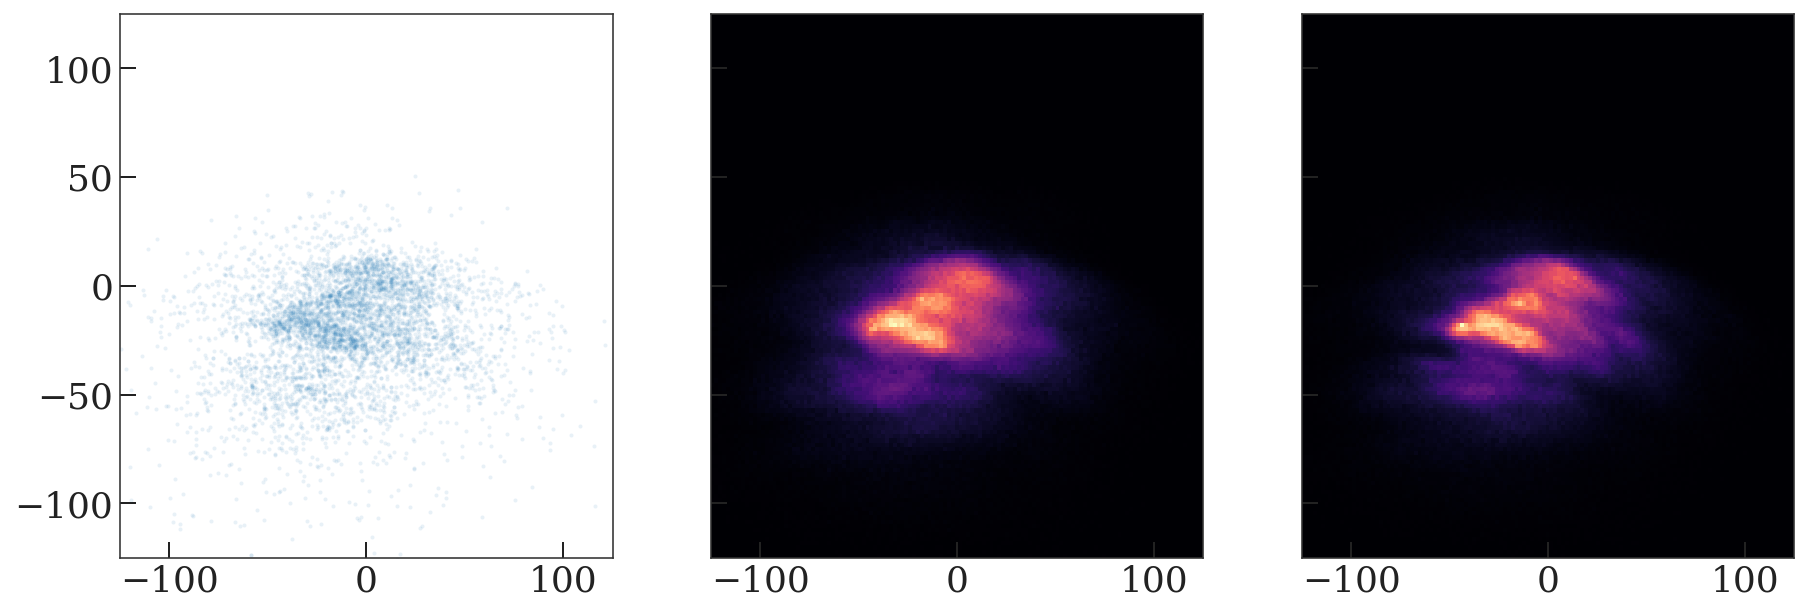

In [63]:
style = dict(marker='o', alpha=0.1, ms=2, ls='none', mew=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5),
                         sharex=True, sharey=True)

axes[0].plot(local_v[:, 0], local_v[:, 1], **style)

bins = np.linspace(-125, 125, 128)
axes[1].hist2d(test_v[:, 0], test_v[:, 1], 
               bins=bins)
axes[2].hist2d(test_v_pred[:, 0], test_v_pred[:, 1], 
               bins=bins)

axes[0].set_xlim(-125, 125)
axes[0].set_ylim(-125, 125)

In [72]:
from scipy.ndimage import gaussian_filter

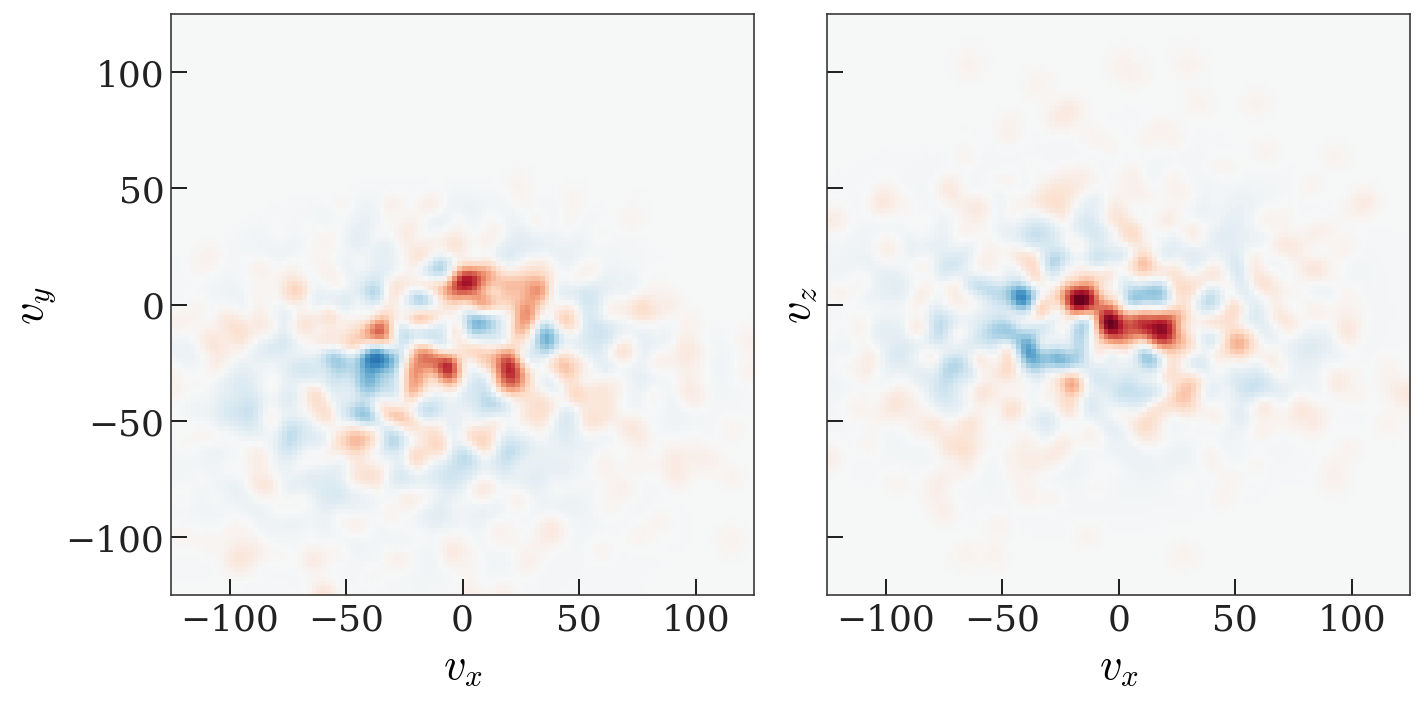

In [77]:
bins = np.linspace(-125, 125, 121)
_f = len(test_v) / len(local_v)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                         sharex=True, sharey=True)

ax = axes[0]
H_test, xe, ye = np.histogram2d(local_v[:, 0], local_v[:, 1], bins=bins)
H_pred, xe, ye = np.histogram2d(test_v_pred[:, 0], test_v_pred[:, 1], bins=bins)
H_test = gaussian_filter(H_test, 2)
H_pred = gaussian_filter(H_pred, 2)
cc = ax.pcolormesh(xe, ye, (H_pred - _f * H_test).T,
                   cmap='RdBu', vmin=-200, vmax=200)
ax.set_xlabel('$v_x$')
ax.set_ylabel('$v_y$')


ax = axes[1]
H_test, xe, ye = np.histogram2d(local_v[:, 0], local_v[:, 2], bins=bins)
H_pred, xe, ye = np.histogram2d(test_v_pred[:, 0], test_v_pred[:, 2], bins=bins)
H_test = gaussian_filter(H_test, 2)
H_pred = gaussian_filter(H_pred, 2)
cc = ax.pcolormesh(xe, ye, (H_pred - _f * H_test).T,
                   cmap='RdBu', vmin=-200, vmax=200)

ax.set_xlabel('$v_x$')
ax.set_ylabel('$v_z$')

# fig.colorbar(cc)
fig.tight_layout()

### Refine training set:

Now we predict on the full training set to see which stars are pulled the least - this will help us define an even better local sample:

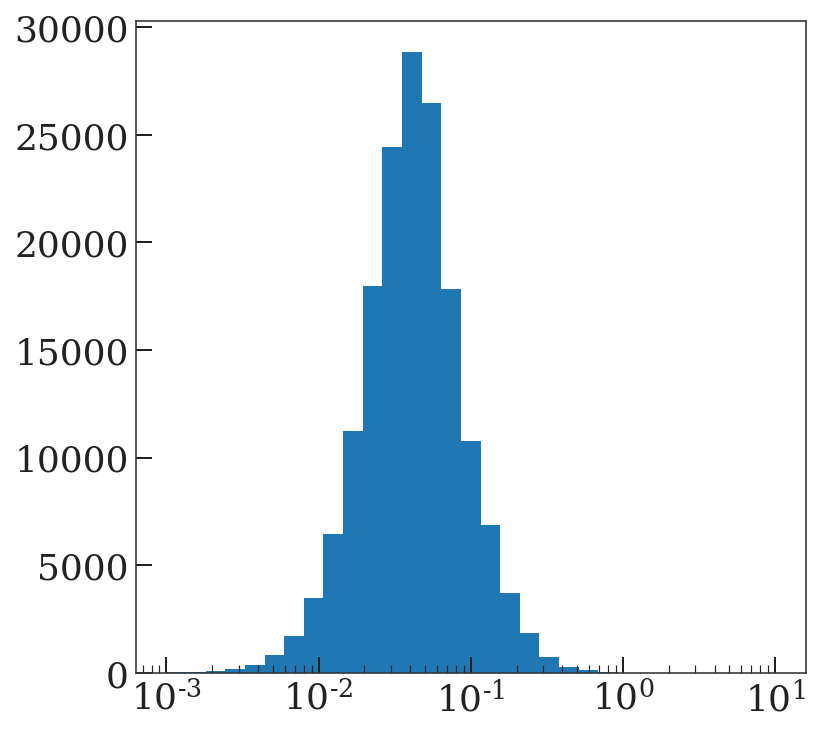

In [104]:
dv = myspace.get_dv(xyz[disk_vmask & mask_r100],
                    UVW[disk_vmask & mask_r100])
dv_mag = np.linalg.norm(dv, axis=1)

# magnitude of velocity shift
# plt.hist(dv_mag, bins=np.logspace(-3, 1, 32));

# fractional velocity shift
v_mag = np.linalg.norm(UVW[disk_vmask & mask_r100], axis=-1)
plt.hist(dv_mag / v_mag, bins=np.logspace(-3, 1, 32));

plt.xscale('log')

In [108]:
# dv_mask = dv_mag < 1
dv_mask = (dv_mag / v_mag) < 1e-2

new_local_x = UVW[disk_vmask & mask_r100][dv_mask]
new_local_v = UVW[disk_vmask & mask_r100][dv_mask]
len(new_local_x)

5659

In [109]:
if not os.path.exists('../cache/myspace-iter1.pkl') or True:
    myspace_iter1 = MySpace(new_local_x, new_local_v)
    res = myspace_iter1.fit(train_x, train_v)

    with open('../cache/myspace-iter1.pkl', 'wb') as f:
        pickle.dump(myspace_iter1, f)
        
else:
    with open('../cache/myspace-iter1.pkl', 'rb') as f:
        myspace_iter1 = pickle.load(f)

In [141]:
R1, s, R2 = np.linalg.svd(myspace_iter1.A)

In [142]:
def get_angles(R):
    tx = np.arctan2(R[2,1], R[2,2])
    ty = np.arctan2(-R[2,0], np.sqrt(R[2,1]**2 + R[2,2]**2))
    tz = np.arctan2(R[1,0], R[0,0])
    return tx, ty, tz

---

In [132]:
test_x = np.array([[0, 1000., 0.]])
test_v = np.array([[0, 10., 0.]])

pred_test_v = myspace_iter1.get_pred_v(test_x, test_v)
pred_test_v

array([[-12.42993687,   5.42812303,  -9.53930774]])

In [137]:
test_x = np.array([[0, -1000., 0.],
                   [0, 1000., 0]])
test_v = np.array([[0, 10., 0.],
                   [0, 10., 0.]])
myspace_iter1.get_dv(test_x, test_v)

array([[ 12.42993687,   4.57187697,   9.53930774],
       [-12.42993687,  -4.57187697,  -9.53930774]])

In [97]:
UVW_fix = myspace_iter1.get_pred_v(xyz, UVW)
# UVW_fix = myspace.get_pred_v(xyz, UVW)

In [98]:
R_mask = (np.sqrt(xyz[:, 0]**2 + xyz[:, 1]**2) < 750.) & (np.abs(xyz[:, 2]) < 500)
close_mask = (np.sqrt(xyz[:, 0]**2 + xyz[:, 1]**2) < 150.) & (np.abs(xyz[:, 2]) < 200)

Text(0, 0.5, '$v_z$')

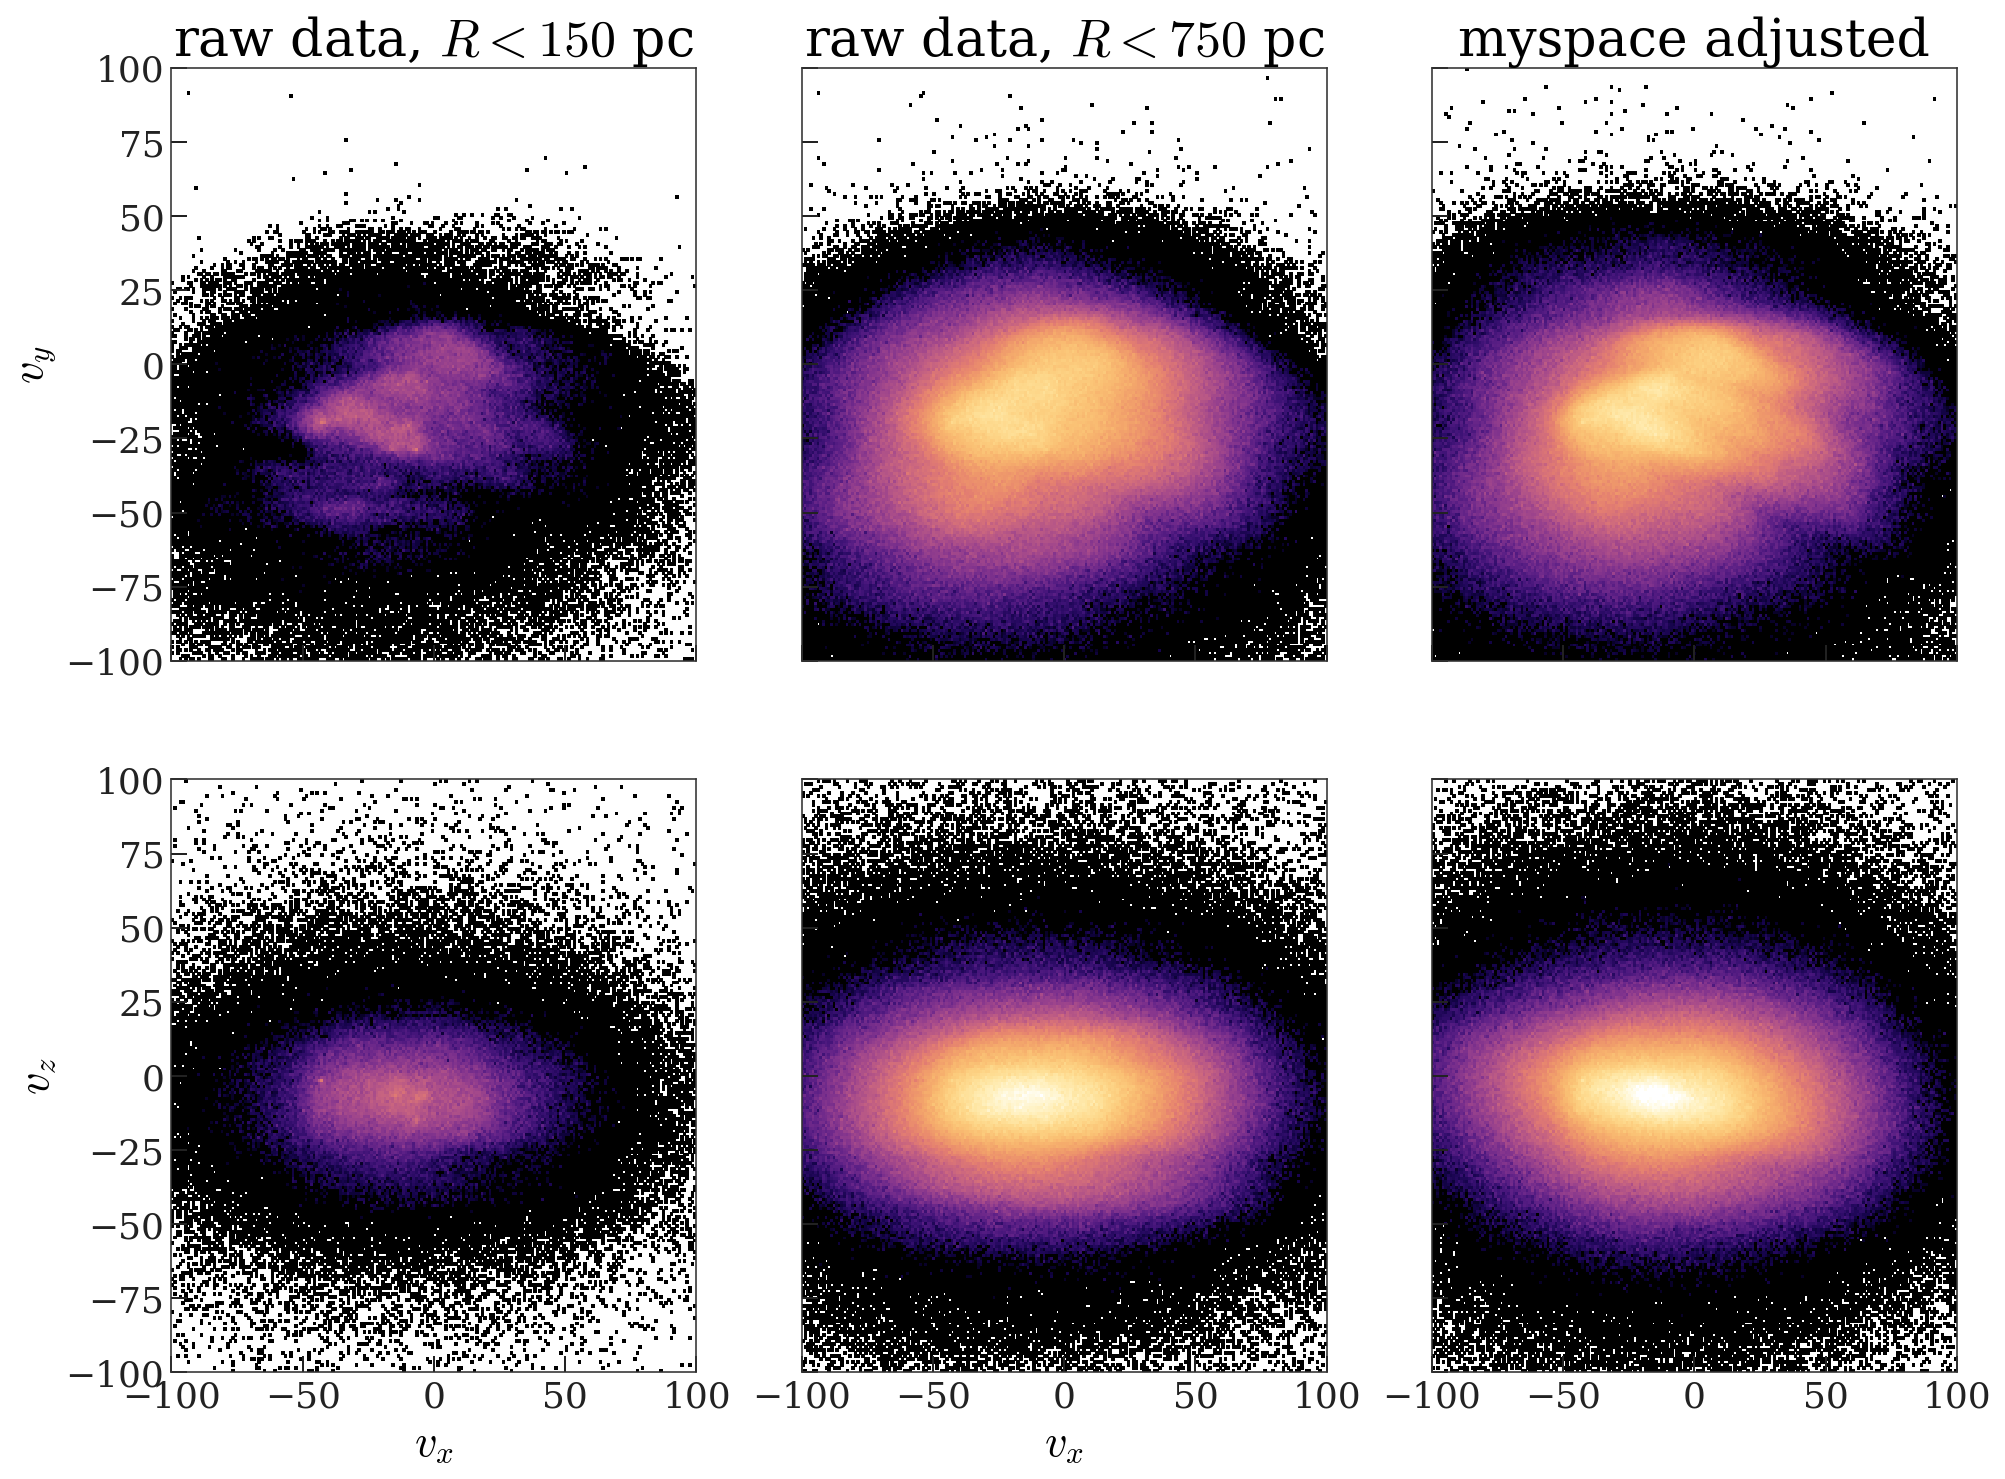

In [111]:
fig, all_axes = plt.subplots(2, 3, figsize=(16, 12),
                             sharex=True, sharey=True)

bins = np.arange(-100, 100+1e-3, 1)
style = dict(cmap='hesperia', norm=mpl.colors.LogNorm(10, 1e3))

axes = all_axes[0]

H, xe, ye = np.histogram2d(UVW[close_mask, 0], UVW[close_mask, 1],
                           bins=bins)
axes[0].pcolormesh(xe, ye, H.T, **style)

H, xe, ye = np.histogram2d(UVW[R_mask, 0], UVW[R_mask, 1],
                           bins=bins)
axes[1].pcolormesh(xe, ye, H.T, **style)

H, xe, ye = np.histogram2d(UVW_fix[R_mask, 0], UVW_fix[R_mask, 1],
                           bins=bins)
axes[2].pcolormesh(xe, ye, H.T, **style)

axes[0].set_title('raw data, $R < 150$ pc')
axes[1].set_title('raw data, $R < 750$ pc')
axes[2].set_title('myspace adjusted')

# axes[0].set_xlabel('$v_x$')
# axes[1].set_xlabel('$v_x$')
axes[0].set_ylabel('$v_y$')

axes = all_axes[1]
H, xe, ye = np.histogram2d(UVW[R_mask, 0], UVW[R_mask, 2],
                           bins=bins)
axes[1].pcolormesh(xe, ye, H.T, **style)

H, xe, ye = np.histogram2d(UVW_fix[R_mask, 0], UVW_fix[R_mask, 2],
                           bins=bins)
axes[2].pcolormesh(xe, ye, H.T, **style)

H, xe, ye = np.histogram2d(UVW_fix[close_mask, 0], UVW_fix[close_mask, 2],
                           bins=bins)
axes[0].pcolormesh(xe, ye, H.T, **style)

axes[0].set_xlabel('$v_x$')
axes[1].set_xlabel('$v_x$')
axes[0].set_ylabel('$v_z$')

# fig.savefig('raw-vs-myspace-750.png', dpi=250)